<a href="https://colab.research.google.com/github/denisecammarota/icgpu/blob/main/clases/CUDA_Clase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%html
<marquee style='width: 100%; color: blue;'><b>ICNPG2021 en Google Colaboratory-Instituto Balseiro-Clase 1 </b></marquee>


# Preparativos para programar CUDA C/C++ en google colabs

Hola!, Bueno, aqui va un ejemplito de como correr codigo CUDA C/C++ en colabs
[[1]](https://https://www.wikihow.com/Run-CUDA-C-or-C%2B%2B-on-Jupyter-(Google-Colab)
[[2]](https://stackoverflow.com/questions/56854243/how-to-link-the-libraries-when-executing-cuda-program-on-google-colab).

No se olviden de Runtime-> Change Runtime Type -> GPU. Para que funque a cada linea la tienen que ejecutar con un Shift-Enter o Ctrl-Enter o el botoncito de play.

miremos que version de nvcc tenemos

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


A ver que placa nos toco...

In [ ]:
!nvidia-smi

Thu Apr 22 13:33:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

lindas GPUs!!. Ahora, para poder correr Cuda C/C++ instalamos un plugin

Veamos que cpu tenemos...

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

Como vamos a programar en cuda C/C++ vamos a necesitar instalar un plugin

In [ ]:
!pip install git+git://github.com/droyktton/nvcc4jupyter.git

  Cloning git://github.com/droyktton/nvcc4jupyter.git to /tmp/pip-req-build-lua4vqa9
  Running command git clone -q git://github.com/droyktton/nvcc4jupyter.git /tmp/pip-req-build-lua4vqa9
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp37-none-any.whl size=4307 sha256=7c756e28b0a5e90baf713566141a2252c5df0ce5a8719bf4dc5e0acb7ed9ce63
  Stored in directory: /tmp/pip-ephem-wheel-cache-5caph07s/wheels/7e/b6/05/ede7d144a248167c9dae0589e0162b6d3094ebca2998edb1de
Successfully built NVCCPlugin


y luego cargarlo:

In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


Listo!, con eso ya podemos correr codigo CUDA C/C++ en el notebook Jupyter.

Para terminar, es conveniente montar nuestro google drive, asi podemos acceder a nuestros archivos, que pueden ser headers, etc. Nos va a pedir un permiso y un codigo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Multiplicacion de Matrices

Solucion con bibliotecas. Para que ande hay que hacerlo en dos partes. Primero generar el codigo en una carpeta local del server:


In [ ]:
%%cuda --name matmul.cu
#include<stdio.h>
#include <cuda_runtime.h>
#include "/content/drive/MyDrive/gpu_timer.h"
#include "/content/drive/MyDrive/cpu_timer.h"
#include<cublas_v2.h>
#include<cublasXt.h>
#include <fstream>

// dimension de la matriz por default
#ifndef DIM
#define DIM	16
#endif

// si prefiere trabajar con indices de fila y columna 
// estos macros son utiles:

// C[IDX2C(i,j,M)] == valor en fila i (=0,...,Width-1) columna (j=0,1,...Height-1), row-major-C
#define  IDX2C(i,j,ld) (((j)*(ld))+( i )) 

// C[IDX2F(i,j,M)] == valor en fila i (=1,...,Width) columna (j=1,...Height), column-major-F
#define IDX2F(i,j,ld) ((((j)-1)*(ld))+((i)-1)) 


// Matrices are stored in row-major order:
// M(row, col) = *(M.elements + row * M.width + col)
// Matrices are stored in column-major order:
// M(row, col) = *(M.elements + col * M.width + row)
typedef struct {
    int width;
    int height;
    float* elements;
} Matrix;

// Thread block size
#define BLOCK_SIZE 16


// activamos todas las APIs
#define SIMPLECPU
#define SIMPLECUDA
#define SIMPLECUDASHARED
#define CUBLAS
#define CUBLASXt


////////////////////////////////////////////////////////////////////////
// Forward declaration of the matrix multiplication kernel

__global__ void MatMulKernel(const Matrix, const Matrix, Matrix);

__global__ void MatMulKernelShared(const Matrix, const Matrix, Matrix);


// Matrix multiplication - Host code
// Matrix dimensions are assumed to be multiples of BLOCK_SIZE
void MatMul(const Matrix A, const Matrix B, Matrix C,int opt)
{
    // Load A and B to device memory
    Matrix d_A;
    d_A.width = A.width; d_A.height = A.height;
    size_t size = A.width * A.height * sizeof(float);
    cudaMalloc(&d_A.elements, size);
    cudaMemcpy(d_A.elements, A.elements, size,
               cudaMemcpyHostToDevice);
    Matrix d_B;
    d_B.width = B.width; d_B.height = B.height;
    size = B.width * B.height * sizeof(float);
    cudaMalloc(&d_B.elements, size);
    cudaMemcpy(d_B.elements, B.elements, size,
               cudaMemcpyHostToDevice);

    // Allocate C in device memory
    Matrix d_C;
    d_C.width = C.width; d_C.height = C.height;
    size = C.width * C.height * sizeof(float);
    cudaMalloc(&d_C.elements, size);

    // Invoke kernel
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    dim3 dimGrid(B.width / dimBlock.x, A.height / dimBlock.y);
 
    if(opt==0) MatMulKernel<<<dimGrid, dimBlock>>>(d_A, d_B, d_C);
    else MatMulKernelShared<<<dimGrid, dimBlock>>>(d_A, d_B, d_C);

    // Read C from device memory
    cudaMemcpy(C.elements, d_C.elements, size,
               cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_A.elements);
    cudaFree(d_B.elements);
    cudaFree(d_C.elements);
}


// Matrix multiplication kernel called by MatMul()
__global__ void MatMulKernel(Matrix A, Matrix B, Matrix C)
{
    // Each thread computes one element of C
    // by accumulating results into Cvalue
    float Cvalue = 0;
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    // En "C-row-major" order seria 
    /*for (int e = 0; e < A.width; ++e)
        Cvalue += A.elements[row * A.width + e]
                * B.elements[e * B.width + col];
    C.elements[row * C.width + col] = Cvalue;
    */	

    // "column-major" order
    for (int e = 0; e < A.width; ++e)
    	Cvalue += A.elements[row + e*A.width]
        * B.elements[e + col * B.width];

    C.elements[row + col * C.width] = Cvalue;
}

// Matrix multiplication kernel called by MatMul()
__global__ void MatMulKernelShared(Matrix A, Matrix B, Matrix C)
{
    // aqui vamos a cargar la secuencia de "tiles" de A y B
    __shared__ float Atile[BLOCK_SIZE][BLOCK_SIZE];
    __shared__ float Btile[BLOCK_SIZE][BLOCK_SIZE];

    // Cada hilo calcula un elemento de C
    float Cvalue = 0;
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    //recorremos los tiles
    for(int m=0;m<A.width/BLOCK_SIZE;m++){

      // los hilos cooperan para cargar los tiles de A y B en shared memory
      Atile[threadIdx.y][threadIdx.x]=A.elements[(m*BLOCK_SIZE+threadIdx.x)*A.width+row];
      Btile[threadIdx.y][threadIdx.x]=B.elements[col*B.width+(m*BLOCK_SIZE+threadIdx.y)];
      __syncthreads();

      // contribucion de los tiles al elemento C que calcula cada hilo
      for (int e = 0; e < BLOCK_SIZE; ++e)
      	Cvalue += Atile[threadIdx.y][e]*Btile[e][threadIdx.x];
      __syncthreads();
    }
    C.elements[row + col * C.width] = Cvalue;
}


////////////////////////////////////////////////////////////////////////
// Matrix multiplication in cpu (column-major)
void MatMulcpu(Matrix A, Matrix B, Matrix C)
{
    for(int row=0; row<A.width;row++){
    	for(int col=0; col<A.height;col++){
    		float Cvalue = 0;
    		for (int e = 0; e < A.width; ++e)
        		Cvalue += A.elements[row + e*A.width]
                	* B.elements[e + col * B.width];

    		C.elements[row + col * C.width] = Cvalue;
    	}
    }
}



////////////////////////////////////////////////////////////////////////
// cublasXt API:
// como cublas, pero recibe matrices input y output del HOST
// se encarga de todas las alocaciones en device copias HD y DH 
void MatMulCublasXt(const Matrix A, const Matrix B, Matrix C)
{
	float  al=1.0f;                 
	float bet =0.0f;
	int m=C.width;

	cublasXtHandle_t manija;
	cublasXtCreate(&manija);

	int devices[1] = { 0 }; 
	cublasXtDeviceSelect(manija, 1, devices);

	cublasXtSgemm(manija,CUBLAS_OP_N,CUBLAS_OP_N,m,m,m,&al,A.elements,m,B.elements,m,&bet,C.elements,m);

	cublasXtDestroy(manija);
}



////////////////////////////////////////////////////////////////////////
// cublas API:
// como cublas, pero recibe matrices input y output del DEVICE
// nos tenemos que encargar de todas las alocaciones en device y copias HD y DH 
void MatMulCublas(const Matrix A, const Matrix B, Matrix C)
{
    // Load A and B to device memory
    Matrix d_A;
    d_A.width = A.width; d_A.height = A.height;
    size_t size = A.width * A.height * sizeof(float);
    cudaMalloc(&d_A.elements, size);
    //cudaMemcpy(d_A.elements, A.elements, size, cudaMemcpyHostToDevice);

    Matrix d_B;
    d_B.width = B.width; d_B.height = B.height;
    size = B.width * B.height * sizeof(float);
    cudaMalloc(&d_B.elements, size);
    //cudaMemcpy(d_B.elements, B.elements, size, cudaMemcpyHostToDevice);

    // Allocate C in device memory
    Matrix d_C;
    d_C.width = C.width; d_C.height = C.height;
    size = C.width * C.height * sizeof(float);
    cudaMalloc(&d_C.elements, size);

    // buena costumbre: hacer algo con los codigos de error
        cublasStatus_t stat;

    float  al=1.0f;                 
    float bet =0.0f;
    int m=C.width;

    cublasHandle_t manija;
    stat=cublasCreate(&manija);

    // Esto:
        //cudaMemcpy(A.elements, d_A.elements, size,cudaMemcpyDeviceToHost);
    //cudaMemcpy(B.elements, d_B.elements, size,cudaMemcpyDeviceToHost);
    //cudaMemcpy(C.elements, d_C.elements, size,cudaMemcpyDeviceToHost);
    // Es equivalente a esto:
    stat = cublasSetMatrix(m,m,sizeof(float),(A.elements),m,(d_A.elements) ,m);//a -> d_a
    stat = cublasSetMatrix(m,m,sizeof(float),(B.elements),m,(d_B.elements) ,m);//b -> d_b
    stat = cublasSetMatrix(m,m,sizeof(float),(C.elements),m,(d_C.elements) ,m);//c -> d_c

    // multiplication
    stat=cublasSgemm(manija,CUBLAS_OP_N,CUBLAS_OP_N,m,m,m,&al, d_A.elements,m,d_B.elements,m, &bet, d_C.elements,m);

    // La variable stat se puede usar asi (recomendado para todas las llamadas...)
    if (stat != CUBLAS_STATUS_SUCCESS)
        {
            fprintf(stderr, "!!!! CUBLAS Sgemm error\n");
            exit(1);
        }

        // Hacer esto:
        //cudaMemcpy(C.elements, d_C.elements, size,cudaMemcpyDeviceToHost);
    // es equivalente a esto:
    stat=cublasGetMatrix(m,m,sizeof(float),(d_C.elements) ,m,(C.elements),m);	//d_c->c

      // Free device memory
      cublasDestroy(manija); // liberamos las "variables ocultas" de cublas
      cudaFree(d_A.elements);
      cudaFree(d_B.elements);
      cudaFree(d_C.elements);
}


////////////////////////////////////////////////////////////////////////
// imprime matrix C ordenada a lo "fortran", column-major 
void print_matrix(Matrix C,std::ofstream &fout){
	// para evitar imprimir demasiado, imprimimos sub-matriz de max x max
	int max=128;
	int maxheight=(C.height>max)?(max):(C.height);
	int maxwidth=(C.width>max)?(max):(C.width);

	int i,j;
	for(i=0;i<maxheight;i++){
		for(j=0;j<maxwidth-1;j++){
			fout << C.elements[j*C.width+i] << " ";
		}
		fout << C.elements[j*C.width+i] << "\n";
	}
}


int main(int argc, char **argv)
{
	// Usaremos, por simplicidad, matrices cuadradas de NxN
	// N viene del primer argumento de la linea de comandos, sino se fija a DIM=1024 
	int N;
	if(argc>1){
		N=atoi(argv[1]);
	}else N=DIM;

	// matrices para hacer C=A*B	
        Matrix A, B, C;

	// inicializacion de las dimensiones de las matrices (cuadradas por simplicidad)
	A.width=B.width=C.width=A.height=B.height=C.height=N; 
	
    	size_t size = A.width * A.height * sizeof(float);

	// alocacion de matrices en el HOST
	A.elements=(float *)malloc(size);
	B.elements=(float *)malloc(size);
	C.elements=(float *)malloc(size);

	// inicializacion de matrices en el HOST
	for(int i=0;i<A.width*A.height;i++)
	{
		// matriz aleatoria
		A.elements[i]=rand()*1.f/RAND_MAX;
		//B.elements[i]=rand()*1.f/RAND_MAX;

		// matriz identidad
		B.elements[i]=(i%(A.width+1)==0)?(1.0f):(0.0f);
		C.elements[i]=0.0f;
	}

	std::ofstream foutA("A.dat");
	std::ofstream foutB("B.dat");
	print_matrix(A,foutA);
	print_matrix(B,foutB);

	// objeto timer de CPU (¿porque de CPU?)
	cpu_timer reloj_cpu;


	#ifdef SIMPLECPU
	reloj_cpu.tic();
	MatMulcpu(A,B,C);
	printf("N= %d simple cpu: %f ms\n", N, reloj_cpu.tac());
	std::ofstream foutCPU("Ccpu.dat");
	print_matrix(C,foutCPU);
	#endif

	#ifdef SIMPLECUDA
	MatMul(A,B,C,0); //warmup
	reloj_cpu.tic();
	MatMul(A,B,C,0);
	printf("N= %d simple_CUDA: %f ms\n",N, reloj_cpu.tac());
	std::ofstream foutSC("Ccuda.dat");
	print_matrix(C,foutSC);
	#endif

	#ifdef SIMPLECUDASHARED
	MatMul(A,B,C,1); //warmup
	reloj_cpu.tic();
	MatMul(A,B,C,1);
	printf("N= %d simple_CUDA_shared: %f ms\n",N, reloj_cpu.tac());
	std::ofstream foutSCs("Ccudashared.dat");
	print_matrix(C,foutSCs);
	#endif


	#ifdef CUBLAS
	MatMulCublas(A,B,C); //warmup
	reloj_cpu.tic();
	MatMulCublas(A,B,C);
	printf("N= %d cublas: %f ms\n", N, reloj_cpu.tac());
	std::ofstream foutCUBLAS("Ccublas.dat");
	print_matrix(C,foutCUBLAS);
	#endif


	#ifdef CUBLASXt
	MatMulCublasXt(A,B,C); //warmup
	reloj_cpu.tic();
	MatMulCublasXt(A,B,C);
	printf("N= %d cublasXt: %f ms\n", N, reloj_cpu.tac());
	std::ofstream foutCUBLASXt("Ccublasxt.dat");
	print_matrix(C,foutCUBLASXt);
	#endif


        return 0;
}


'File written in /content/src/matmul.cu'

y luego compilarlo

In [ ]:
!nvcc -o /content/src/matmul /content/src/matmul.cu -lcublas -DDIM=1024

y ejecutarlo

In [ ]:
!/content/src/matmul

N= 1024 simple cpu: 7921.937681 ms
N= 1024 simple_CUDA: 45.084050 ms
N= 1024 simple_CUDA_shared: 8.815072 ms
N= 1024 cublas: 6.342038 ms
N= 1024 cublasXt: 7.568428 ms


A x B = Ccpu


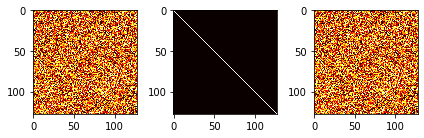

A x B = Cgpu (naive)


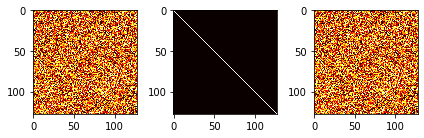

A x B = Cgpu (shared)


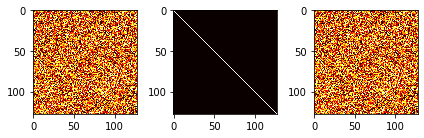

A x B = Cgpu (cublas)


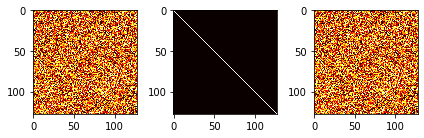

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

A = np.loadtxt("A.dat", dtype='f', delimiter=' ')
B = np.loadtxt("B.dat", dtype='f', delimiter=' ')
Ccpu = np.loadtxt("Ccpu.dat", dtype='f', delimiter=' ')
Cgpu = np.loadtxt("Ccuda.dat", dtype='f', delimiter=' ')
Cgpu2 = np.loadtxt("Ccudashared.dat", dtype='f', delimiter=' ')
Cgpu3 = np.loadtxt("Ccublas.dat", dtype='f', delimiter=' ')

print("A x B = Ccpu")

plt.subplot(1,3,1)
plt.imshow(A, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,2)
plt.imshow(B, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,3)
plt.imshow(Ccpu, cmap='hot', interpolation='nearest')

plt.tight_layout()
plt.show()

print("A x B = Cgpu (naive)")

plt.subplot(1,3,1)
plt.imshow(A, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,2)
plt.imshow(B, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,3)
plt.imshow(Cgpu, cmap='hot', interpolation='nearest')

plt.tight_layout()
plt.show()


print("A x B = Cgpu (shared)")

plt.subplot(1,3,1)
plt.imshow(A, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,2)
plt.imshow(B, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,3)
plt.imshow(Cgpu2, cmap='hot', interpolation='nearest')

plt.tight_layout()
plt.show()



print("A x B = Cgpu (cublas)")

plt.subplot(1,3,1)
plt.imshow(A, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,2)
plt.imshow(B, cmap='hot', interpolation='nearest')
#plt.show()

plt.subplot(1,3,3)
plt.imshow(Cgpu3, cmap='hot', interpolation='nearest')

plt.tight_layout()
plt.show()


# Reducción



In [ ]:
%%cuda --name reduccion.cu

#include <iostream>
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/reduce.h>
#include <thrust/execution_policy.h>
#include <thrust/fill.h>
#include <ctime>
#include <sys/time.h>
#include <sstream>
#include <string>
#include <fstream>
#include "/content/drive/MyDrive/gpu_timer.h"
#include "/content/drive/MyDrive/cpu_timer.h"

using namespace std;
typedef float tipo;

// esto esta mal, ¿porque?
__global__ void reduce_mal(tipo *g_idata, int size)
{
   unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;

   for(unsigned int s=size/2; s>0; s>>=1)
   { 
        if (i < s) {
         g_idata[i] += g_idata[i + s];
        }
   }
}

// esto esta bien, pero es muy lento, ¿porque?
__global__ void reduce_atomics(tipo *g_idata, int size)
{
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;

    if(i>0 && i<size) atomicAdd(&g_idata[0], g_idata[i]);
}


// block reduction
__global__ void reduce_shared(tipo *g_idata, tipo *g_odata, int size){

   extern __shared__ tipo sdata[];

   unsigned int tid = threadIdx.x;
   unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
   sdata[tid] = 0;
 
   // carga de datos de global a shared memory
   if(i<size)
     sdata[tid] = g_idata[i];
   __syncthreads();

   // reduccion en arbol sequential addressing
   for(unsigned int s=blockDim.x/2; s>0; s>>=1) 
   {
      if (tid < s) {
         sdata[tid] += sdata[tid + s];
      }
      __syncthreads();
   }

   if (tid == 0) atomicAdd(&g_odata[0], sdata[0]);;
}

// block reduction
__global__ void reduce_global(tipo *g_idata, tipo *g_odata, int size){

   unsigned int tid = threadIdx.x;
   unsigned int i0 = blockIdx.x*blockDim.x;
   unsigned int i=i0+tid;

   // reduccion en arbol sequential addressing
   for(unsigned int s=blockDim.x/2; s>0; s>>=1) 
   {
      if (tid < s) {
         g_idata[i] += g_idata[i + s];
      }
      __syncthreads();
   }

   if (tid == 0) atomicAdd(&g_odata[0], g_idata[i0]);
}


#define SIZE 10


int main(int argc, char **argv){

  assert(argc==3);
  int size = atoi(argv[1]);
  //int size = SIZE; 

  // crea un vector de host de size "ints" y lo inicializa a 1
  thrust::host_vector<tipo> data_h_i(size, 1);
  srand(1); for(int i=0;i<data_h_i.size();i++) data_h_i[i]=(rand()*1.0/RAND_MAX);

  //initialize the data, all values will be 1
  //so the final sum will be equal to size
  int threadsPerBlock = 256;
  int totalBlocks = (size+(threadsPerBlock-1))/threadsPerBlock;

  // una forma de "empaquetar" vectores de device usando thrust
  // crea y aloca un vector de device de "int" y copia el contenido de un vector de host 
  thrust::device_vector<tipo> data_v_i = data_h_i;

  // crea y aloca un vector de device de totalBlocks elementos "int" 
  thrust::device_vector<tipo> data_v_o(totalBlocks);

  // los vectors de device son algo mas que un punter a memoria de device
  tipo* output = thrust::raw_pointer_cast(data_v_o.data());
  tipo* input = thrust::raw_pointer_cast(data_v_i.data());


  gpu_timer reloj;
  cpu_timer relojcpu;
  int sum=0;

  int opt=atoi(argv[2]);
  //int opt=OPT;

  switch(opt){
	case 0:	
	reloj.tic();
   reduce_mal<<<totalBlocks, threadsPerBlock, threadsPerBlock*sizeof(int)>>>(input, size);
	std::cout << "reduccion erronea: " << data_v_i[0] << " (dio bien?) en " << reloj.tac() << " ms" << std::endl;
	break;

   case 1:	
	reloj.tic();
   reduce_atomics<<<totalBlocks, threadsPerBlock, threadsPerBlock*sizeof(int)>>>(input, size);
	std::cout << "reduccion con atomics: " << data_v_i[0] << " (dio bien?) en " << reloj.tac() << " ms" << std::endl;
	break;

	case 2:
	reloj.tic();
   reduce_shared<<<totalBlocks, threadsPerBlock, threadsPerBlock*sizeof(int)>>>(input, output, size);
   std::cout << "reduccion en arbol con shared: " << data_v_o[0] << " (dio bien?) en " << reloj.tac() << " ms" << std::endl;
	break;

	case 3:
	reloj.tic();
   reduce_global<<<totalBlocks, threadsPerBlock>>>(input, output, size);
   std::cout << "reduccion en arbol con global: " << data_v_o[0] << " (dio bien?) en " << reloj.tac() << " ms" << std::endl;
	break;

	case 4:
	reloj.tic();
  	// todo lo anterior se puede hacer en una línea usando la biblioteca thrust 
	sum = thrust::reduce(thrust::device,input,input+size);
  	cout << "reduccion con thrust en device: " << sum 
	     << " (dio bien?) en " << reloj.tac() << " ms" << std::endl;
	break;

	case 5:
	relojcpu.tic();
	sum = thrust::reduce(data_h_i.begin(),data_h_i.end());
  	cout << "reduccion con thrust en host: " << sum << " (dio bien?) en " << relojcpu.tac() << " ms" << std::endl;
	break;

  case 6:
	relojcpu.tic();
	sum = 0;
   for(int i=0;i<data_h_i.size();i++) sum+=data_h_i[i];
  	cout << "reduccion naive en host: " << sum << " (dio bien?) en " << relojcpu.tac() << " ms" << std::endl;
	break;

}
  return 0;

}


'File written in /content/src/reduccion.cu'

In [ ]:
!nvcc -O2 /content/src/reduccion.cu -o reduccion

In [ ]:
!for l in 1 2 3 4 5 6; do /content/reduccion 33445532 $l; done

reduccion con atomics: 1.67228e+07 (dio bien?) en 114.476 ms
reduccion en arbol con shared: 1.67228e+07 (dio bien?) en 2.72435 ms
reduccion en arbol con global: 1.67228e+07 (dio bien?) en 3.75946 ms
reduccion con thrust en device: 16722932 (dio bien?) en 0.981568 ms
reduccion con thrust en host: 16722810 (dio bien?) en 49.4481 ms
reduccion naive en host: 3 (dio bien?) en 203.079 ms


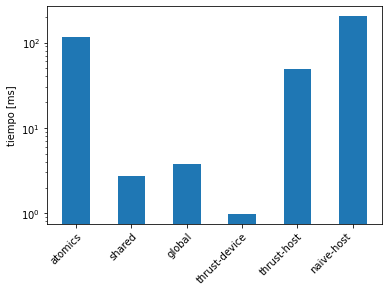

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 6
##completar los tiempos aqui... en orden de aparicion
tiempos = (114.476 ,2.72435,3.75946, 0.981568,49.4481, 203.079)
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
ax.set_xticklabels(('atomics','atomics', 'shared','global','thrust-device', 'thrust-host', 'naive-host'))
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('tiempo [ms]')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

p1 = ax.bar(ind, tiempos, width)
plt.show()